# Making an artificial Digital Surface Model
Sander Aarts, Spetember 2022.

This notebook demonstrates how one can add building height data to a bare-earth elevation model.
- Some areas such as Geneva, NY have a digital evelation model (DEM) but no digial surface model (DSM).
- A DEM is a model of elevation of the bare earth, excluding structures. A DSM includes structures.
- Often building footprints and heights are available. This is the case for Geneva, NY.
- In this notebook we merge a DEM with building footprint and height data.
- This produces an artificial DSM.
- One limitation is that buildings are assumed to be flat-roofed.

We will use the __Town of Geneva, NY__ as a running example.

- The building footprints from [Ontario County](https://ontariocountyny.gov/1156/Ontario-County-GIS-Data-Resource-Center)

In [21]:
# load packages
import fiona
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import rioxarray as rxr
from shapely.geometry import mapping
import warnings

# packages for plotting
import matplotlib.pyplot as plt
import contextily as cx

In [2]:
# coorinate reference ststems
web = 'epsg:3857'
utm = "EPSG:26918"  # https://epsg.io/26918 

## Load and Organize Input Data

In [3]:
# load extent for plotting
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
extent = gpd.read_file('input_data/geneva_extent.kml', driver='KML')

# drop duplicitous 'area' in gdf
extent.drop(extent[extent['Name']!='geneva_larger'].index, inplace=True)
extent.geometry = extent.geometry.envelope
print("Loaded an area with CRS: \t" + str(extent.crs))

Loaded an area with CRS: 	epsg:4326


### Load Digital Evelation Model (DEM) bare-earth model

In [5]:
# load DEM (bare earth) raster
dem = rxr.open_rasterio("input_data/geneva_dem.tif", masked=True).squeeze()
print("Loaded raster with CRS: \t" + str(dem.rio.crs))

# crop raster to extent
dem = dem.rio.clip(extent.geometry.apply(mapping), extent.crs)

# rename attribute name
dem.attrs['long_name'] = 'Elevation (m)'

Loaded raster with CRS: 	EPSG:4269


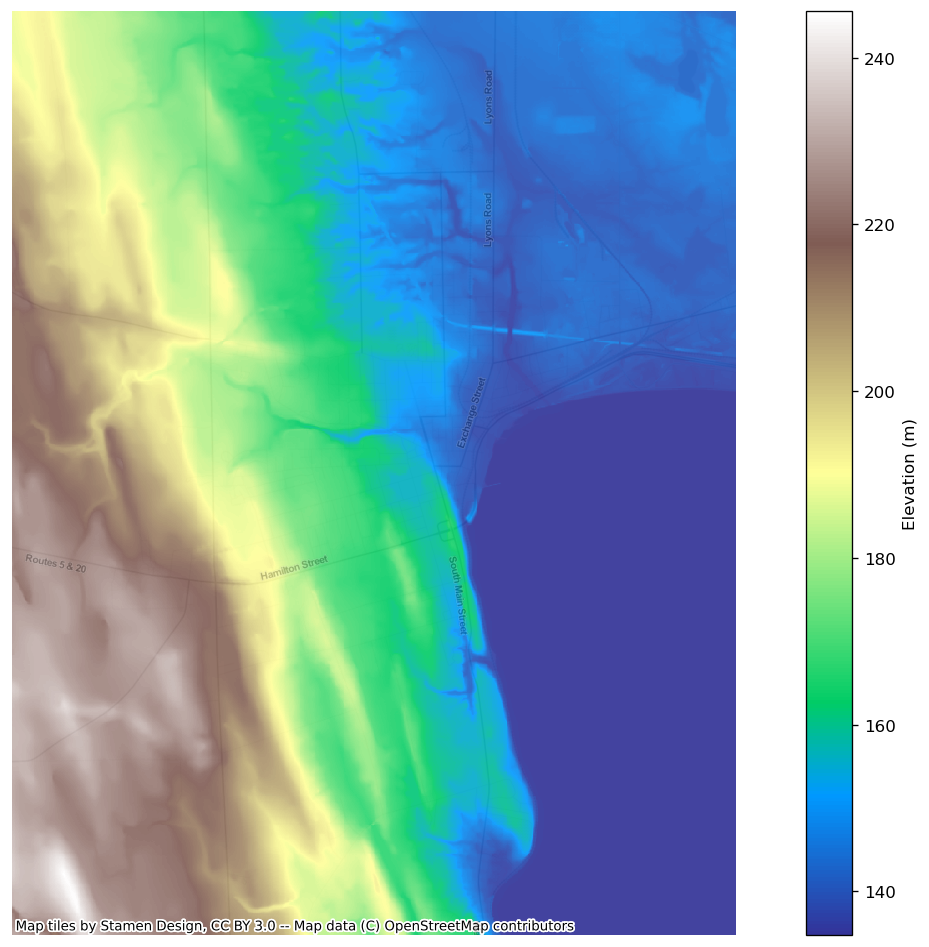

In [7]:
# plot DEM
fig, ax = plt.subplots(figsize=(12,8), dpi=120)
dem.rio.reproject(web).plot.imshow(ax=ax, cmap='terrain', add_colorbar=True, alpha=1)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, alpha=.1)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, alpha=.2)
ax.set(title=None)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('figures/dem_thumbnail.png')
plt.show()

- Observe that the DEM is im meters (m)
- While some built terrain such as ramps of viaducts are visible, there are no buildings.

### Load building data

In [8]:
# load building shapefiles
blds = gpd.read_file('input_data/ontario_buildings/oc_BuildingFootprints.shp')
blds = blds.to_crs(extent.crs)
print("Loaded %d buildings with crs %s." % (blds.shape[0], str(blds.crs)))

# drop building outside extent
blds.drop(blds[~blds.geometry.within(extent.iloc[0].geometry)].index, inplace=True)
print("Retained %d buildings inside study extent." % blds.shape[0])

# get building height in m
blds['height'] = blds['HEIGHT'] * 0.3048  # convert to m
print("%d buildings lack height data." % (blds.height == 0).sum())
print("The maximum height is %.1f." % blds.height.max())

Loaded 74943 buildings with crs epsg:4326.
Retained 7455 buildings inside study extent.
1756 buildings lack height data.
The maximum height is 93.0.


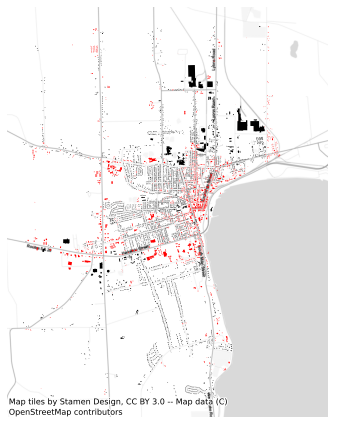

In [9]:
# plot blds
fig, ax = plt.subplots(figsize=(6,6))
extent.to_crs(web).plot(ax=ax, alpha=.0)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
blds[blds.height > 0].to_crs(web).plot(ax=ax, alpha=1, edgecolor='None', facecolor='k')
blds[blds.height == 0].to_crs(web).plot(ax=ax, alpha=1, edgecolor='None', facecolor='red')
ax.set(title=None)
ax.set_axis_off()
plt.tight_layout()
plt.show()

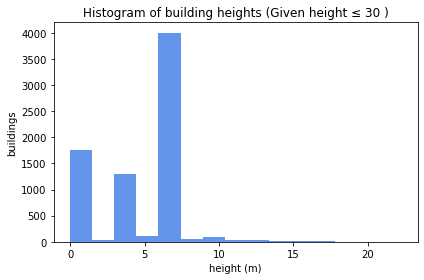

In [10]:
# plot building heights (should have modes at typical values)
fig, ax = plt.subplots(figsize=(6, 4))
maxHeight = 30
ax.hist(blds[blds['height'] < maxHeight]['height'], bins=15, color='cornflowerblue')
ax.set_title("Histogram of building heights (Given height ≤ %d )" % maxHeight)
ax.set_ylabel("buildings")
ax.set_xlabel("height (m)")
plt.tight_layout()
plt.show()

# Imputing missing data

There are many ways to impute missing data.

- The `Prop_Class` column contains a [NYS tax code](https://www.tax.ny.gov/pdf/ORPTS/property-class-codes.pdf).
    - Some property classes can contain information regarding the height of a building.

In [11]:
# Compute imputed heights
heights = blds[blds.height > 0].groupby('Prop_Class')['height'].mean().to_dict()
stdevs = blds[blds.height > 0].groupby('Prop_Class')['height'].std().to_dict()
classes = list(heights.keys())

blds['imputed'] = False
imputable = (blds.height==0) & blds['Prop_Class'].isin(classes)
blds.loc[imputable, 'height'] = blds[imputable]['Prop_Class'].map(heights)
blds.loc[imputable, 'std'] = blds[imputable]['Prop_Class'].map(stdevs)
blds.loc[imputable, 'imputed'] = True

print("%d buildings lack height data." % (blds.height == 0).sum())
print("The maximum height is %.1f." % blds.height.max())

464 buildings lack height data.
The maximum height is 93.0.


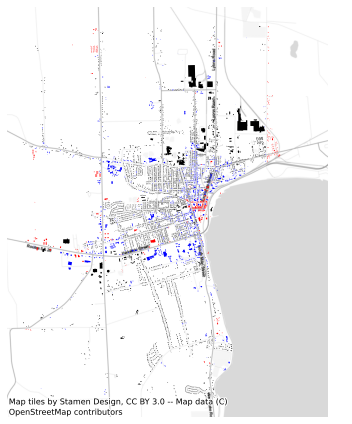

In [12]:
# plot blds
fig, ax = plt.subplots(figsize=(6,6))
extent.to_crs(web).plot(ax=ax, alpha=.0)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
blds[(blds.height > 0) & ~blds.imputed].to_crs(web).plot(ax=ax, alpha=1, edgecolor='None', facecolor='k')
blds[(blds.height > 0) & blds.imputed].to_crs(web).plot(ax=ax, alpha=1, edgecolor='None', facecolor='b')
blds[blds.height == 0].to_crs(web).plot(ax=ax, alpha=1, edgecolor='None', facecolor='red')
ax.set(title=None)
ax.set_axis_off()
plt.tight_layout()
plt.show()

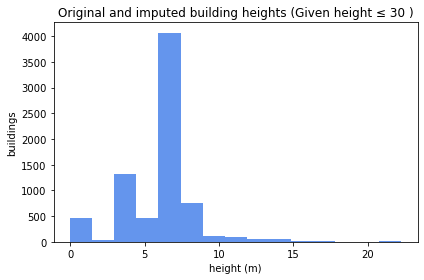

In [13]:
# plot building heights (should have modes at typical values)
fig, ax = plt.subplots(figsize=(6, 4))
maxHeight = 30
ax.hist(blds[blds['height'] < maxHeight]['height'], bins=15, color='cornflowerblue')
ax.set_title("Original and imputed building heights (Given height ≤ %d )" % maxHeight)
ax.set_ylabel("buildings")
ax.set_xlabel("height (m)")
plt.tight_layout()
plt.savefig('figures/hist_building_height.png')
plt.show()

## Comparing with building on OSM

Not all buildings are represented in `blds`. Let's compare with OpenStreetMaps.

In [14]:
# get centroid of extent lat / lon
lon = extent.geometry.to_crs(utm).centroid.to_crs("EPSG:4326").x.values[0]
lat = extent.geometry.to_crs(utm).centroid.to_crs("EPSG:4326").y.values[0]

# load OSM buildings in a 5km radius
blds2 = ox.geometries.geometries_from_point((lat, lon), {'building': True}, dist=10000)
print("Loaded %d buildings from OSM." % blds2.shape[0])
blds2.reset_index(drop=True, inplace=True)

# drop non-Polygon rows
blds2.drop(blds2[blds2.geometry.type != 'Polygon'].index, inplace=True)
print("Retained %d buildings with Polygon geometries." % blds2.shape[0])

# Drop buildings outside extent
blds2['in_extent'] = [extent.contains(blds2.geometry.iloc[i]).values[0] for i in range(blds2.shape[0])]
blds2.drop(blds2[~blds2['in_extent']].index, inplace=True)
print("Retained %d buildings inide the extent." % blds2.shape[0])

Loaded 14129 buildings from OSM.
Retained 14128 buildings with Polygon geometries.
Retained 6207 buildings inide the extent.


In [15]:
# identify OSM buildings with no corresponding building in blds
temp = blds2.to_crs(utm).sjoin_nearest(blds.to_crs(utm),
                                       how='left', max_distance=300,
                                       distance_col='dist_to_nearest')
temp.drop(temp[temp['dist_to_nearest'] == 0].index, inplace=True)
print("Found %d buildings not in `blds`." % temp.shape[0])

Found 159 buildings not in `blds`.


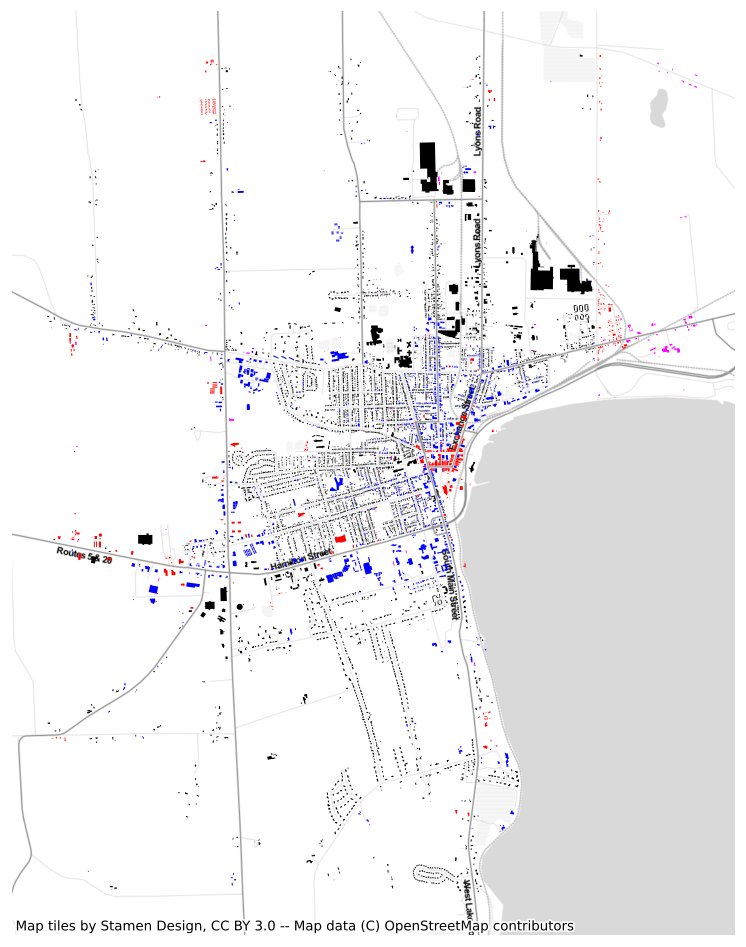

In [16]:
# plot OSM buildings and original buildings

# divide data
original = blds[(blds.height > 0) & ~blds.imputed].to_crs(web)
imputed = blds[(blds.height > 0) & blds.imputed].to_crs(web)
missing = blds[blds.height == 0].to_crs(web)

# make plot
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=DeprecationWarning)
    fig, ax = plt.subplots(figsize=(12,8), dpi=120)
    extent.to_crs(web).plot(ax=ax, alpha=.0)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    original.plot(ax=ax, alpha=1, edgecolor='None',facecolor='k')
    imputed.plot(ax=ax, alpha=1, edgecolor='None', facecolor='b',)
    missing.plot(ax=ax, alpha=1, edgecolor='None', facecolor='red')
    temp.to_crs(web).plot(ax=ax, edgecolor='None', facecolor='magenta')

    # set style
    ax.set(title=None)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig('figures/building_footprints.png')
    plt.show()

In [17]:
# merge blds2 with temp
final = gpd.GeoDataFrame(pd.concat((blds, temp[['geometry']]), ignore_index=True))

# mark new additions as imputed
final.loc[final['imputed'].isna(), 'imputed'] = True
final.loc[final['height'].isna(), 'height'] = 0

print("%d buildings lack height data." % (final.height == 0).sum())
print("The maximum height is %.1f." % final.height.max())

623 buildings lack height data.
The maximum height is 93.0.


## Impute by nearest neighbor


In [18]:
# split data by height availability
neighbors = final[final.height > 0][['geometry', 'height']].copy()
missings = final[final.height == 0].copy()

# harmonize crs
neighbors = neighbors.to_crs(utm)
missings = missings.to_crs(utm)

In [19]:
# get height from nearest neighbor
missings = missings.sjoin_nearest(neighbors)
final.loc[final.height == 0, 'height'] = missings['height_right']

print("%d buildings lack height data." % (final.height == 0).sum())
print("The maximum height is %.1f." % final.height.max())

0 buildings lack height data.
The maximum height is 93.0.


# Apply buildings to DEM

In [20]:
# harmonize crs
final = final.to_crs(epsg=4269)
print(final.crs)
print(dem.rio.crs)

epsg:4269
EPSG:4269


In [ ]:
# get a DSM (may take a while)
dsm = dem.copy()
for index, bld in final.iterrows():
    clipped = dem.rio.clip([bld.geometry], drop=False)  # drop=False retains shape of dem
    dsm = dsm.where(np.isnan(clipped), clipped.mean() + bld.height)

In [ ]:
# plot DSM
fig, ax = plt.subplots(figsize=(12,8), dpi=120)
dsm.rio.reproject(web).plot.imshow(ax=ax, cmap='terrain', add_colorbar=True)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, alpha=.1)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, alpha=.2)
ax.set(title=None)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('figures/dsm_thumbnail.png')
plt.show()

In [ ]:
# save dsm as .tif
dsm.rio.to_raster("geneva_dsm.tif")